# Double DQN - Atari Breakout

In [1]:
#!pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117 #CUDA versions of pytorch
#!pip install ale_py
#!pip install ipywidgets
#!pip install --upgrade gym[atari,accept-rom-license]

In [2]:
import random
import statistics
import gym
import sys
import torch
import numpy as np
import torch.nn as nn
import os
import torch.optim as optim
import torchvision.transforms as T
import matplotlib.pyplot as plt

from collections import OrderedDict, deque
from tqdm import tqdm
from PIL import Image

%matplotlib inline
np.set_printoptions(threshold=sys.maxsize)

In [3]:
print(torch.cuda.is_available())
if torch.cuda.is_available():
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

True
1
NVIDIA GeForce RTX 3070 Ti Laptop GPU


In [4]:
# Parameters
output_rgb = True
render_mode = "rgb_array"
#render_mode = "human"

env = gym.make('ALE/Breakout-v5', render_mode=render_mode)
env.metadata['render_fps'] = 60
print(env.unwrapped.get_action_meanings())
action_size = env.action_space.n

# Hyperparameters
epsilon_decay = 0.0001
batch_size = 32
lr = 0.0003
discount_factor = 0.99
update_frequency = 5

memory_len = 10000
episodes = 30000
test_episodes = 100
test_episodes = 10

if not os.path.isdir("output"):
    os.mkdir("output")

if render_mode == "rgb_array" and output_rgb is True:
    if not os.path.isdir("output/images"):
        os.mkdir("output/images")

    if not os.path.isdir("output/images_test"):
        os.mkdir("output/images_test")

    for episode in range(episodes):
        if not os.path.isdir(f"output/images/{episode}"):
            os.mkdir(f"output/images/{episode}")

    for episode in range(test_episodes):
        if not os.path.isdir(f"output/images_test/{episode}"):
            os.mkdir(f"output/images_test/{episode}")

['NOOP', 'FIRE', 'RIGHT', 'LEFT']


In [5]:
# This class defines the neural network structure for Deep Q
class DQNetwork(nn.Module):
    def __init__(self, output_size, lr):
        super(DQNetwork, self).__init__() # nn.Module super class
        self.linear_model = nn.Sequential(OrderedDict([
            ('conv0', nn.Conv2d(4, 32, kernel_size=8, stride=4)),
            ('relu0', nn.ReLU()),
            ('conv1', nn.Conv2d(32, 64, 4, 2)),
            ('relu1', nn.ReLU()),
            ('conv2', nn.Conv2d(64, 64, 3, 1)),
            ('relu2', nn.ReLU()),
            ('flatten0', nn.Flatten()),
            ('dense0', nn.Linear(7*7*64, 512)),
            ('relu3', nn.ReLU()),
            ('dense1', nn.Linear(512, output_size))
            ]
        ))
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
    
    # Performs forward pass in the network
    def fowardPass(self, x):
        x = self.linear_model(x)
        return x

In [6]:
'''
Initital two DQN networks - one is the policy network and the other is the target network
'''
class DQNAgent:
    def __init__(self, action_size, epsilon_decay, batch_size, lr, discount_factor, memory_len):
        self.action_size = action_size
        self.memory = deque(maxlen=memory_len)
        
        self.epsilon = 1.0 #starting epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = 0.01
        self.batch_size = batch_size
        self.learning_rate = lr
        self.discount_factor = discount_factor
        
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        
        self.policy_net = DQNetwork(self.action_size, self.learning_rate).to(self.device)
        self.target_net = DQNetwork(self.action_size, self.learning_rate).to(self.device)
        self.updateTargetPolicy()
        
    '''
    Function definition for choosing an action based on ɛ-greedy policy. 
        i.e For P(1-ɛ) => argmax(Qt(a))
        else for P(ɛ) => random(a)
    '''
    def getAction(self, current_state_vector):
        rand_num = np.random.random()
        if rand_num < self.epsilon:
            return np.random.randint(self.action_size)
        else:
            if not torch.is_tensor(current_state_vector):
                current_state_vector = torch.from_numpy(current_state_vector).float().to(self.device)
            
            with torch.no_grad():
                q_values = self.policy_net.fowardPass(current_state_vector).view(-1,)
            best_action = torch.argmax(q_values).item()
        return best_action
    
    '''
    Update the target network parameters based on the policy network parameters
    '''
    def updateTargetPolicy(self):
        self.target_net.load_state_dict(self.policy_net.state_dict())

    '''
    Implements epsilon decay
    ''' 
    def updateEpsilon(self):
        self.epsilon -= (self.epsilon * self.epsilon_decay)
        return self.epsilon
    
    '''
    Apply preprocessing to the captured frame/state
    '''
    def preprocessState(self, state):
        img = state[34:-16, :, :]
        resize = T.Compose([
                    T.ToPILImage(),
                    T.Grayscale(),
                    T.Resize((84, 84)),
                    T.ToTensor()
                ])
        img = resize(img)
        return img.to(self.device)

    '''
    Train the neural network
    '''
    def trainModel(self):
        if len(self.memory) > self.batch_size:
            mini_batch = random.sample(self.memory, self.batch_size)
            current_state = torch.tensor([]).float().to(self.device)
            actions = list()
            rewards = list()
            next_states = torch.tensor([]).float().to(self.device)
            dones = list()
            
            # Append each memory values in the separate lists
            for i in range(self.batch_size):
                state, action, reward, next_state, done_boolean = mini_batch[i]
                current_state = torch.cat((current_state, state)).float().to(self.device)
                actions.append(action)
                rewards.append(reward)
                next_states = torch.cat((next_states, next_state)).float().to(self.device)
                dones.append(done_boolean)
            
            # Convert each list to torch tensors
            actions = torch.from_numpy(np.array(actions)).to(self.device)
            rewards = torch.from_numpy(np.array(rewards)).float().to(self.device)
            dones = torch.from_numpy(np.array(dones)).to(self.device)

            # Make a forward pass in the policy network based on the current state
            # and choose the q-value of the action
            policy_q_values = self.policy_net.fowardPass(current_state).gather(1, actions.view(-1,1).type(torch.int64)).view(-1,)

            # Make a forward pass in the target network based on the next state
            # and choose the q-value of the action which gives the highest q-value
            policy_best_actions = self.policy_net.fowardPass(next_states).argmax(dim=1).view(-1,1)
            target_q_values = self.target_net.fowardPass(next_states).gather(1, policy_best_actions).view(-1,)
            
            # Compute the target
            y_target = list()
            for index, value in enumerate(target_q_values):
                if dones[index]:
                    y_target.append(rewards[index])
                else:
                    y_target.append(rewards[index] + self.discount_factor * value)
            
            y_target = torch.stack(y_target, dim=0) # Create the list to torch tensor

            # Calculate the MSE loss and perform a backward pass in the policy network
            criterion = nn.MSELoss()
            loss = criterion(y_target, policy_q_values)
            self.policy_net.optimizer.zero_grad()
            loss.backward()

            self.policy_net.optimizer.step()

    def run(self, env, numEpisodes, isTest):
        total_reward_arr = list()
        cumulative_reward_arr = list() # Store cumulative reward
        frames_arr = list() # Store the num of frames per episode
        avg_frames_arr = list() # Store average num of frames every 50 episodes
        train_frame = 4

        if isTest is True:
            self.epsilon = 0  # Agent only chooses greedy actions from the learnt policy

        for episode in tqdm(range(numEpisodes)):
            done = False
            total_reward = 0
            agent_lives = 5
            frames = 0
            env.reset()

            obs, _, _, _, _ = env.step(1) # 1 is FIRE action

            current_state = self.preprocessState(obs)
            current_state = torch.cat((current_state, current_state, current_state, current_state)).unsqueeze(0) # 1-4-84-84
    
            while not done:
                action = self.getAction(current_state)
                next_state, reward, terminated, truncated, info = env.step(action)
                done = terminated|truncated

                renderOutput = env.render()
                if render_mode == "rgb_array" and output_rgb is True:
                    new_im = Image.fromarray(renderOutput)
                    base_dir = "images_test" if isTest else "images"
                    new_im.save(f"output/{base_dir}/{episode}/frame_{frames+1}.png")

                next_state = self.preprocessState(next_state) # 84-84
                next_state_history = torch.cat((current_state.squeeze(0)[1:, :, :], next_state)).unsqueeze(0) # 1-4-84-84

                if isTest is False:
                    self.memory.append((current_state, action, reward, next_state_history, done)) #Add experience to the experience replay deque. deque removes oldest element when max size is reached.
                    if frames % train_frame == 0:
                        self.trainModel()

                total_reward += reward
                frames += 1
                        
                if agent_lives > info['lives']: # dead
                    obs, _, _, _, _ = env.step(1)
                    
                    obs = self.preprocessState(obs)
                    current_state = torch.cat((current_state.squeeze(0)[2:, :, :], next_state, obs)).unsqueeze(0)
                    agent_lives = info['lives']
                else:
                    current_state = next_state_history

            frames_arr.append(frames)
            # Calculate average frames for every 50 episodes
            if (episode+1) % 50 == 0:
                avg_frames_arr.append(np.average(frames_arr))
                frames_arr.clear()

            total_reward_arr.append(total_reward)

            if isTest is False:
                if episode % update_frequency == 0:
                    self.updateTargetPolicy()

                ep = self.updateEpsilon()

                if np.mean(total_reward_arr[-10:]) > 200:
                    break

            if len(cumulative_reward_arr) == 0:
                cumulative_reward = total_reward
            else:
                cumulative_reward = cumulative_reward_arr[-1] + total_reward
            cumulative_reward_arr.append(cumulative_reward)
        
        return (total_reward_arr, cumulative_reward_arr, avg_frames_arr) 
    
    '''
    Save trained model.
    '''
    def saveModel(self, filename):
        torch.save(self.policy_net.state_dict(), filename)
    
    '''
    Load trained model.
    '''
    def load_model(self, filename):
        self.policy_net.load_state_dict(torch.load(filename))

In [7]:
agent = DQNAgent(action_size, epsilon_decay, batch_size, lr, discount_factor, memory_len)
total_reward_arr, cumulative_reward_arr, avg_frames_arr = agent.run(env, episodes, False)

agent.saveModel("output/DQN_breakout_weights.pth")

100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


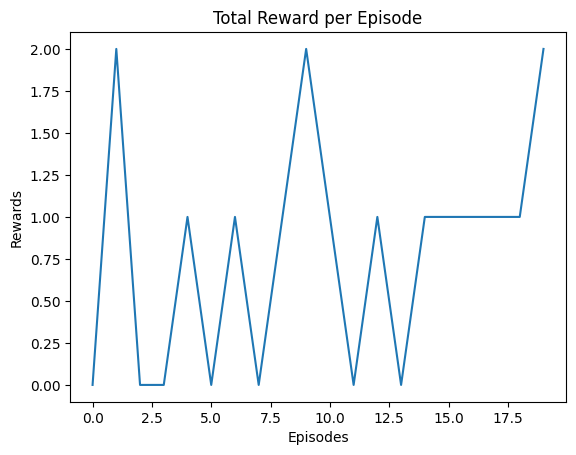

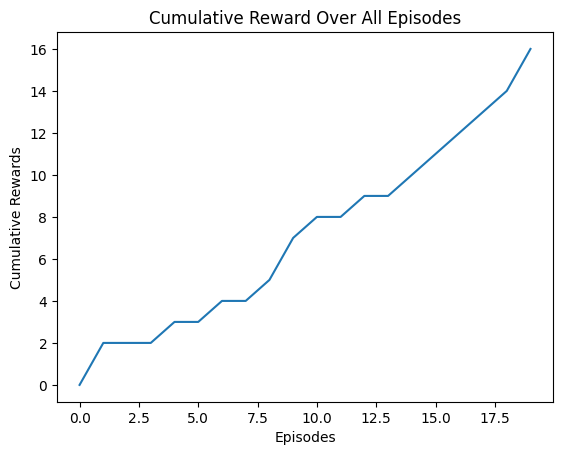

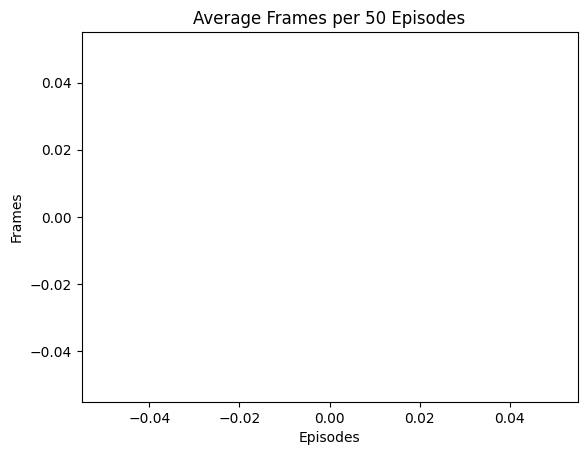

In [8]:
plt.plot(total_reward_arr)
plt.title('Total Reward per Episode')
plt.ylabel('Rewards')
plt.xlabel('Episodes')
plt.savefig('output/reward_per_episode.png', bbox_inches="tight")
plt.show()
plt.close()

plt.plot(cumulative_reward_arr)
plt.title('Cumulative Reward Over All Episodes')
plt.ylabel('Cumulative Rewards')
plt.xlabel('Episodes')
plt.savefig('output/cumulative_reward_overall.png', bbox_inches="tight")
plt.show()
plt.close()

plt.plot(avg_frames_arr)
plt.title('Average Frames per 50 Episodes')
plt.xlabel('Episodes')
plt.ylabel('Frames')
plt.savefig('output/avg_frames_per_50episodes.png', bbox_inches="tight")
plt.show()
plt.close()

In [9]:
arr = np.asarray(total_reward_arr).astype(int)
c = np.savetxt('output/total_reward_arr.txt', arr, fmt='%i', delimiter='\n')
print(statistics.mean(total_reward_arr))
print(arr)

0.8
[0 2 0 0 1 0 1 0 1 2 1 0 1 0 1 1 1 1 1 2]


### Load saved model weights and test the agent for 100 episodes

In [10]:
agent = DQNAgent(action_size, epsilon_decay, batch_size, lr, discount_factor, memory_len)
agent.load_model("output/DQN_breakout_weights.pth")
test_rewards, _, _ = agent.run(env, test_episodes, True)

100%|██████████| 10/10 [00:12<00:00,  1.28s/it]


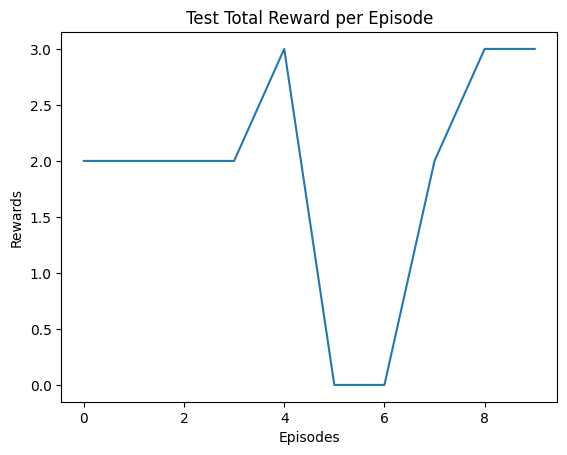

In [11]:
plt.plot(test_rewards)
plt.title('Test Total Reward per Episode')
plt.xlabel('Episodes')
plt.ylabel('Rewards')
plt.savefig('output/test_reward_per_episode.png', bbox_inches="tight")
plt.show()
plt.close()